In [ ]:
!pip install tensorflow==2.4.1

     |████████████████████████████████| 394.3 MB 15 kB/s 
     |████████████████████████████████| 3.8 MB 39.4 MB/s 
     |████████████████████████████████| 462 kB 41.7 MB/s 
     |████████████████████████████████| 2.9 MB 45.4 MB/s 
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68715 sha256=2dbae8588a9bca0c268b39b659beec88b9dcf5f1b2767b3a3343558dc5566cc0
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.2
    Uninstalling typing-extensions-3.10.0.2:
      Successfully uninstalled typing-extensions-3.10.0.2
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.41.1
    Uninstalling grpcio-1.41.1:
      Successfully uninstalled grpcio-1.41.1
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.13.3
    Uninstalling wrapt-1.13.3:
      Suc

The Idea is to apply CNN to Cats&Dogs Image Classification dataset.

In [ ]:
import numpy as np
import pandas as pd
import os

from sklearn.model_selection import train_test_split

import tensorflow as tf

print(tf.__version__)

2.4.1


In [ ]:
# preparing data

TRAIN_DIR = "Data/train_cdd"
TEST_DIR = "Data/test_cd"

TRAIN_SIZE = len([name for name in os.listdir(TRAIN_DIR)])
TEST_SIZE = len([name for name in os.listdir(TEST_DIR)])
print("Number of training images:", TRAIN_SIZE)
print("Number of test images:", TEST_SIZE)

Number of training images: 1881
Number of test images: 300


In [ ]:
VALID_FRACTION = 0.2
BATCH_SIZE = 100
EPOCHS = 50

IMAGE_WIDTH = IMAGE_HEIGHT = 150

# creating df with train labels
train_filenames = os.listdir(TRAIN_DIR)
train_labels = []
for filename in train_filenames:
    label = filename.split('.')[0]
    train_labels.append(label)

train_df = pd.DataFrame({
    'id': train_filenames,
    'label': train_labels
})

In [ ]:
# splitting to train & valid
train_df, valid_df = train_test_split(train_df, test_size=VALID_FRACTION)

# augmentation settings, for now just normalizing
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(    
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1./255.,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
    )

# not doing any data augmentation on validation test set
valid_datagen  = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

# creating train and valid generators (not using valid_split to avoid doing data augmentation on validation set)
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    TRAIN_DIR, 
    x_col='id',
    y_col='label',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

valid_generator = valid_datagen.flow_from_dataframe(
    valid_df, 
    TRAIN_DIR, 
    x_col='id',
    y_col='label',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Found 2053 validated image filenames belonging to 2 classes.
Found 514 validated image filenames belonging to 2 classes.


In [ ]:
model = tf.keras.models.Sequential([
    # the images were resized by ImageDataGenerator 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # since we have only 2 classes to predict we can use 1 neuron and sigmoid
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 15, 15, 128)      

In [ ]:

model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.001),
    loss='binary_crossentropy',
    metrics = ['accuracy'], run_eagerly=True)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
    mode='min',
    restore_best_weights=True, 
    verbose=1,
    patience=5)

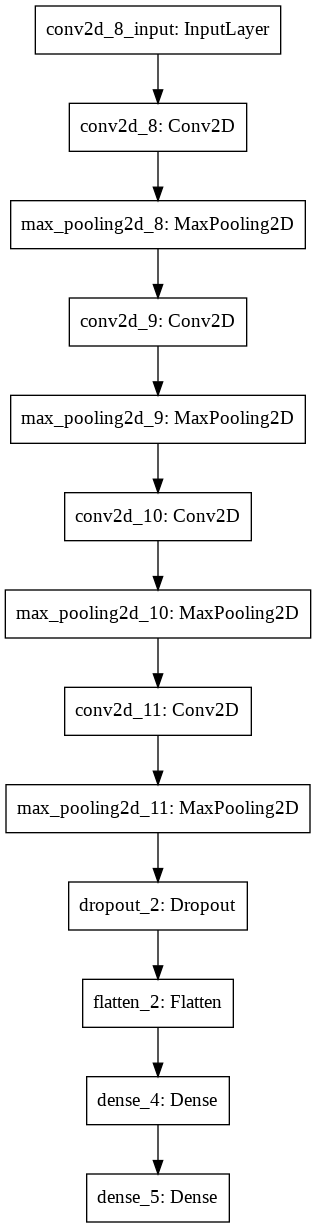

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
tf.config.run_functions_eagerly(True)

In [ ]:
%%time

# training
history = model.fit_generator(train_generator,
    validation_data=valid_generator,
    steps_per_epoch=round(TRAIN_SIZE*(1.-VALID_FRACTION)/BATCH_SIZE),
    validation_steps=round(TRAIN_SIZE*VALID_FRACTION/BATCH_SIZE),
    epochs=EPOCHS,
    callbacks=[es],
    verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
21/21 [==============================] - 21s 998ms/step - loss: 0.9618 - accuracy: 0.4802 - val_loss: 0.6903 - val_accuracy: 0.5080
Epoch 2/50
21/21 [==============================] - 20s 951ms/step - loss: 0.6927 - accuracy: 0.5092 - val_loss: 0.7550 - val_accuracy: 0.5120
Epoch 3/50
21/21 [==============================] - 20s 951ms/step - loss: 0.6893 - accuracy: 0.5469 - val_loss: 0.6850 - val_accuracy: 0.4960
Epoch 4/50
21/21 [==============================] - 20s 969ms/step - loss: 0.6846 - accuracy: 0.5324 - val_loss: 0.6851 - val_accuracy: 0.5260
Epoch 5/50
21/21 [==============================] - 20s 969ms/step - loss: 0.6973 - accuracy: 0.5448 - val_loss: 0.6987 - val_accuracy: 0.4920
Epoch 6/50
21/21 [==============================] - 20s 962ms/step - loss: 0.6828 - accuracy: 0.5506 - val_loss: 0.6799 - val_accuracy: 0.5220
Epoch 7/50
21/21 [==============================] - 20s 959ms/step - loss: 0.6838 - accuracy: 0.5683 - val_loss: 0.6784 - val_accuracy: 0.5620

<Figure size 432x288 with 0 Axes>

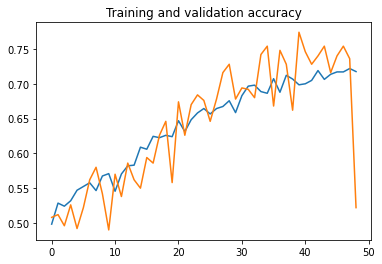

<Figure size 432x288 with 0 Axes>

In [ ]:
#plotting

import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc = history.history['accuracy']
val_acc = history.history[ 'val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')
plt.figure()

In [ ]:
%%time

# preparing testing data
test_filenames = os.listdir(TEST_DIR)
test_df = pd.DataFrame({
    'id': test_filenames
})

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1.0/255.)

test_generator = test_datagen.flow_from_dataframe(
    test_df, 
    TEST_DIR, 
    x_col='id',
    y_col=None,
    class_mode=None,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    shuffle=False
)

yhat = model.predict_generator(test_generator, steps=np.ceil(TEST_SIZE/BATCH_SIZE))

Found 300 validated image filenames.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


CPU times: user 1.38 s, sys: 51.3 ms, total: 1.43 s
Wall time: 1.38 s


In [ ]:
# sigmoid returns probability between 0 and 1, need to convert it to an integer class
yhat = [1 if y > 0.5 else 0 for y in yhat]

test_df['label'] = yhat

# restoring back to class names (dog|cat)
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['label'] = test_df['label'].replace(label_map)

# encoding according to submission format, 1 = dog, 0 = cat
test_df['label'] = test_df['label'].replace({ 'dog': 1, 'cat': 0 })

In [ ]:
test_df.head()

,id,label
0,1766.jpg,1
1,8030.jpg,0
2,6021.jpg,0
3,1799.jpg,0
4,9448.jpg,0
